## Preprocess data from data/twitter_poll.csv

In [194]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [195]:
twitter_poll_df = pd.read_csv('data/obama_aggregate.csv')
twitter_poll_df.drop(['date', 'Unnamed: 0'], axis=1, inplace=True)
twitter_poll_df.head()

,replies,retweets,favorites,approving
0,6175,13945,76360,57
1,5601,3954,24773,53
2,6368,4581,29044,53
3,3928,9502,46260,53
4,1288,6150,25260,53


## Viualization
Now might be the most convenient time to do some preliminary feature exploration!

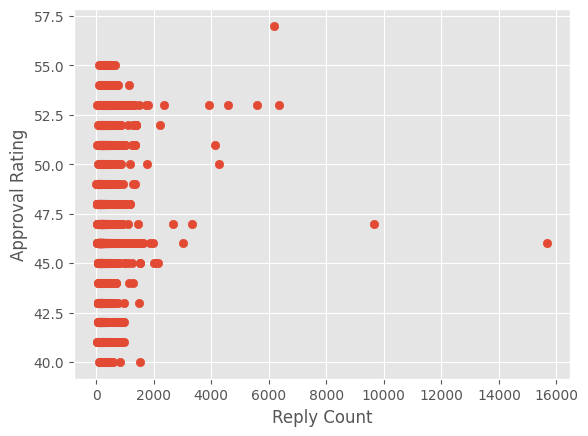

In [199]:
f = plt.figure()
plt.scatter(twitter_poll_df['replies'], twitter_poll_df['approving'])
plt.xlabel('Reply Count')
plt.ylabel('Approval Rating')
plt.show()

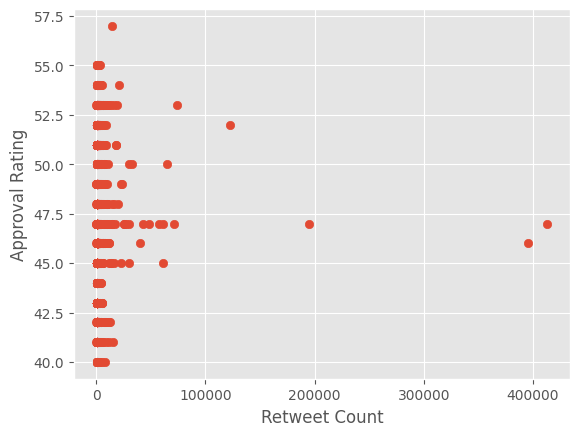

In [200]:
f = plt.figure()
plt.scatter(twitter_poll_df['retweets'], twitter_poll_df['approving'])
plt.xlabel('Retweet Count')
plt.ylabel('Approval Rating')
plt.show()

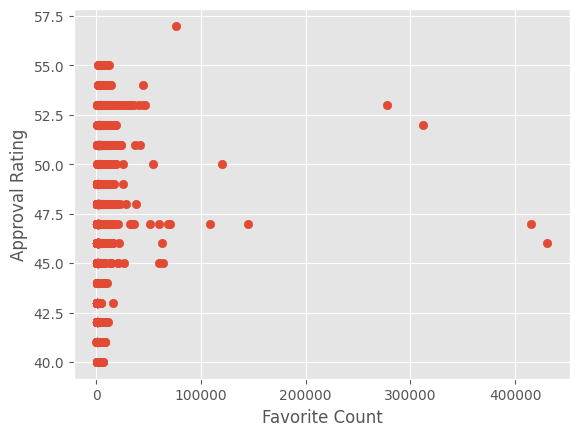

In [201]:
f = plt.figure()
plt.scatter(twitter_poll_df['favorites'], twitter_poll_df['approving'])
plt.xlabel('Favorite Count')
plt.ylabel('Approval Rating')
plt.show()

## Get training and test set

In [23]:
from sklearn.model_selection import train_test_split

approve_estimate = twitter_poll_df['approving']
twitter_poll_df.drop('approving', axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(twitter_poll_df, approve_estimate.values, test_size=0.2)

## Normalization
So at this point, favorites and retweets are the features, $X_{rpc}$, $X_{rtc}$, and $X_{fvc}$ that predict the approval estimate, $Y$. I want to normalize $X_{rpc}$, $X_{rtc}$, and $X_{fvc}$ since retweets are almost always less than favorites.

In [24]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)
print(X_train)
print(X_test)
print(y_train)

[[ 0.10384554 -0.08322727 -0.03736074]
 [-0.08334445 -0.11689649 -0.09923377]
 [-0.37633747 -0.00238975 -0.10261446]
 ...
 [ 1.95743333 -0.07514352  0.05602288]
 [ 0.27882748  0.46175889  0.64911091]
 [-0.47807116 -0.13745904 -0.21092414]]
[[-0.16676607 -0.00576452 -0.08564721]
 [ 0.37242247 -0.00317458 -0.10503835]
 [-0.34581736 -0.09091861 -0.05101108]
 ...
 [ 0.2076139  -0.06674583 -0.17947734]
 [ 0.43346269  0.31209175  0.14181589]
 [-0.38854551 -0.07545745 -0.1348267 ]]
[48 51 46 ... 52 46 43]


## Model selection hunt!
Note: Both regression and classification models will work due to the discrete but numeric nature of the dataset


### Linear Models

In [28]:
from sklearn.linear_model import LinearRegression

regr = LinearRegression()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

### Linear regression metrics

Some observations:
* Coefficient of determination is negative, which originally confused me but after looking at the sklearn.metrics.r2_score documentation I see "it need not actually be the square of a quantity R", but this is indicative of a poor model

In [29]:
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, mean_absolute_error

print('Coefficients: \n', regr.coef_)
print('Mean squared error: %.2f' % mean_squared_error(y_test, y_pred))
print('Coefficient of determination: %.2f' % r2_score(y_test, y_pred))
print('Accuracy: %.2f' % regr.score(X_test, y_test))

Coefficients: 
 [ 0.36875785 -1.85787343  1.83093977]
Mean squared error: 11.10
Coefficient of determination: 0.06
Accuracy: 0.06


### Logistic regression metrics

By default LogisticRegression uses an optimization algorithm that aproximates the Broyden-Fletcher-Goldfarb-Shanno algorithm. 
<br/><br/> Note: Logistic regression is actually a classification method, but since my data is discrete integers, it will still work as a multinominal classification model. 

Observations:
* Highly reduce mean squared error, and coefficient of determination is at least positive now.
* Still does not seem like a very good model

In [38]:
from sklearn.linear_model import LogisticRegression

log_regr = LogisticRegression()
log_regr.fit(X_train, y_train)
y_pred = log_regr.predict(X_test)

C:\Users\kaibo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [39]:
print('Coefficients: \n', log_regr.coef_)
print('Mean squared error: %.2f' % mean_squared_error(y_test, y_pred))
print('Coefficient of determination: %.2f' % r2_score(y_test, y_pred))
print('Accuracy: %.2f' % log_regr.score(X_test, y_test))

Coefficients: 
 [[ 0.67653858  0.21616126 -1.30009515]
 [ 0.69267091  0.71909488 -4.30808196]
 [-0.07627195  3.56655847 -4.6376122 ]
 [-0.18774845 -0.01915228 -4.80381382]
 [ 0.48341058 -0.71611128 -1.08110489]
 [-0.12147153  1.99912278 -0.99850682]
 [ 0.13568588  2.97300801 -2.3544056 ]
 [-0.49493501  2.20592008 -0.68250791]
 [-1.12421409 -0.49274707  2.06367367]
 [-1.05701366  2.14267585 -0.52740689]
 [-0.16170094 -0.95205346  2.54618002]
 [-0.10321522 -2.90024984  3.29375241]
 [-0.13898602 -2.67329269  3.52010506]
 [ 0.23946203 -3.07565915  3.61509796]
 [ 0.03480691 -1.22065589  2.54607019]
 [ 0.12282319 -0.50022744  1.43497316]
 [ 1.08015881 -1.27239221  1.67368278]]
Mean squared error: 11.30
Coefficient of determination: 0.05
Accuracy: 0.22


### Compute metrics for regression function for code reuse

In [202]:
def compute_metrics(regr, X_test, y_test):
    y_pred = regr.predict(X_test)
    print('Mean Squared Error %.2f' % mean_squared_error(y_test, y_pred))
    print('Coefficient of Determination %.2f' % r2_score(y_test, y_pred))
    print('Estimator score %.2f' % regr.score(X_test, y_test))

### Generalized Linear Regression
From scikit-learn: GLM extends linear models in two ways. First, the predicted values $\hat{y}$ are linked to a linear combination of the input variables X via an inverse link function h as $$\hat{y}(w, X) = h(Xw).$$ Secondly, the squared loss function is replaced by the unit deviance d of a distribution in the exponential family (or more precisely, a reproductive exponential dispersion model).<br/> The minimization model becomes: $$\min_{w}\frac{1}{2n_{samples}}\sum_{i}d(y_{i}, \hat{y_{i}}) + \frac{\alpha}{2}||w||_{2}$$

Since the target values are positive valued and skewed, I will try GLM with Gamma deviance. Since $X$ is standardized and the Gamma distribution does not support negative values, I will set link='log' so that the inverse link function will guarantee non-negativeness.

In [203]:
from sklearn.linear_model import TweedieRegressor
regr = TweedieRegressor(alpha=0.5, power=2, link='log')
regr.fit(X_train, y_train)

y_pred = regr.predict(X_test)

In [204]:
compute_metrics(regr, X_test, y_test)

Mean Squared Error 11.65
Coefficient of Determination 0.02
Estimator score 0.02


D^2 score is the percentage of deviance explained, defined to be $$D^2 = 1 - \frac{D(y_{true},y_{pred})}{D_{null}}$$ So this prior result says about 2% of the deviance from the model's prediction to the true value is explained by random error. Not looking very good for the features :( <br/><br/>
Alpha is a constant that multiplies the penalty term ($\frac{1}{2}||w||_{2}$, or L2 norm) and I chose alpha arbitrarily, so I will try an incremental approach to choosing this hyperparameter

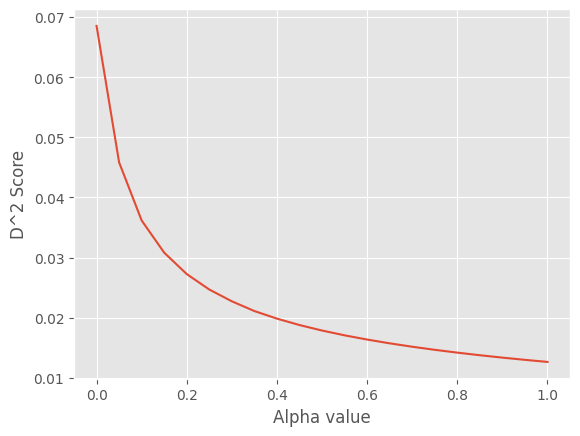

Max value of D^2 is 0.07 achieved at alpha 0.00


In [42]:
max_score = -1000
max_alpha = -1000
cur_alpha = 0

score_list = []
alpha_list = np.linspace(0,1,21)

while cur_alpha < 1.05:
    regr = TweedieRegressor(alpha=cur_alpha, power=2, link='log')
    regr.fit(X_train, y_train)
    cur_score = regr.score(X_test, y_test)
    if(cur_score > max_score):
        max_score = cur_score
        max_alpha = cur_alpha

    score_list.append(cur_score)
    cur_alpha += 0.05

f = plt.figure()
plt.plot(alpha_list, score_list)
plt.xlabel("Alpha value")
plt.ylabel("D^2 Score")
plt.show()
print("Max value of D^2 is %.2f achieved at alpha %.2f" % (max_score,max_alpha))

We can see that $D^2$ is a convex function with respect to $\alpha$, it is intuitive that this is a monotonically decreasing function, considering that the L2 penalization is designed to penalize model complexity.
<br/><br/>
Still though, with an $\alpha$ of 0, we can see that even without penalizing complexity we can only achieve a $D^2$ score of 8%. Time to look at other models!

## Linear models: perliminary conclusion
So I have went ahead and played around with a few other linear models such as BayesianRegression and StochasticGradientDescent, but all scoring metrics have remained under 10%, which leads me to believe that a linear model is not a good choice for this problem. So I will move forward!

## Support Vector Regression

SVR is implemented by solving the following problem:
## $$\min_{w,b,\zeta,\zeta*} \frac{1}{2}w^{T}w + C\sum_{i=1}^{n}(\zeta_{i} + \zeta^{*}_{i})$$
## subject to $$y_{i} - w^{T}\phi(x_{i}) - b \leq \epsilon + \zeta_{i},$$         
##              $$w^{T}\phi(x_{i}) + b - y_{i} \leq \epsilon + \zeta^{*}_{i}$$
##              $$\zeta_{i},\zeta^{*}_{i} \geq 0, i = 1,...,n$$
Note the hyperparameters C and $\epsilon$ that must be chosen. I will use sklearn's GridSearchCV to find these parameters, this function takes a long time, as it is a brute force method. First I will run SVM with default values and then fine tune via GridSearchCV.

In [205]:
from sklearn import svm

regr = svm.SVR()
regr.fit(X_train, y_train)
compute_metrics(regr, X_test, y_test)

Mean Squared Error 7.70
Coefficient of Determination 0.35
Estimator score 0.35


With just the default values of support vector regression the R^2 value is 0.37, significantly higher than any of the linear model scores. 

In [44]:
from sklearn.model_selection import GridSearchCV

parameters = {'kernel': ['rbf'], 'C':[1, 10, 100, 1000, 5000, 10000], 'gamma': [1e-4, 1e-3, 1e-2, 1e-1], 'epsilon': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]}

regr = svm.SVR()
#regr.fit(X_train, y_train)
clf = GridSearchCV(regr, parameters)
clf.fit(X_train, y_train)
clf.best_params_

#print("R^2 score: %.2f" % regr.score(X_test, y_test))

{'C': 1000, 'epsilon': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}

In [206]:
regr = svm.SVR(kernel='rbf', C=1000, gamma=0.1, epsilon=0.1)
regr.fit(X_train, y_train)
compute_metrics(regr, X_test, y_test)

R^2 score: 0.48
Mean Squared Error 6.13
Coefficient of Determination 0.48
Estimator score 0.48


## Nearest Neighbors Regression

In [207]:
from sklearn.neighbors import KNeighborsRegressor

regr = KNeighborsRegressor(weights='distance')
regr.fit(X_train, y_train)
compute_metrics(regr, X_test, y_test)

Mean Squared Error 5.64
Coefficient of Determination 0.52
Estimator score 0.52


In [47]:
parameters={'weights':('uniform','distance'), 'n_neighbors':[2,5,10,12,13,14,15,16,17,20,23]}
clf = GridSearchCV(regr, parameters)
clf.fit(X_train, y_train)
clf.best_params_

{'n_neighbors': 12, 'weights': 'distance'}

In [208]:
regr = KNeighborsRegressor(weights='distance', n_neighbors=12)
regr.fit(X_train, y_train)
compute_metrics(regr, X_test, y_test)


Mean Squared Error 5.29
Coefficient of Determination 0.55
Estimator score 0.55


## Random Forest Regression

In [182]:
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(criterion='mae', max_features='sqrt', random_state=1, min_samples_split=4)

parameters={
    'n_estimators':[250,300,350,400,450]
     }
clf = GridSearchCV(regr, parameters, verbose=3, n_jobs=-1)
clf.fit(X_train, y_train)
clf.best_params_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


{'n_estimators': 450}

Text(0, 0.5, 'R^2')

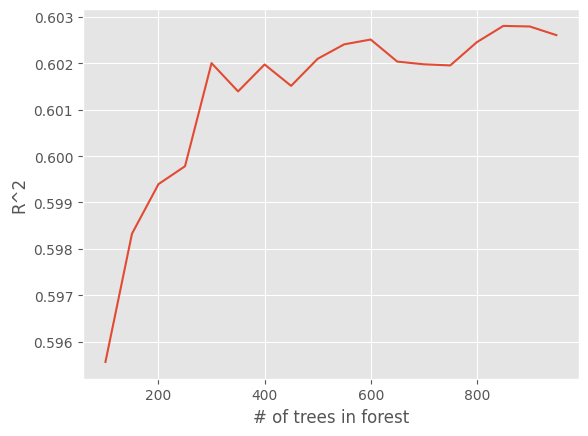

In [186]:
n_estimators_list = [a for a in range(100, 1000, 50)]
score_list = []
for a in n_estimators_list:
    regr = RandomForestRegressor(n_estimators=a,criterion='mae', max_features='sqrt', random_state=1, min_samples_split=4)
    regr.fit(X_train, y_train)
    score_list.append(regr.score(X_test,y_test))

f = plt.figure()
plt.plot(n_estimators_list, score_list)
plt.xlabel('# of trees in forest')
plt.ylabel('R^2')

In [209]:

regr = RandomForestRegressor(n_estimators=850,criterion='mae', max_features='sqrt', random_state=1, min_samples_split=4)
regr.fit(X_train, y_train)
compute_metrics(regr, X_test, y_test)

Mean Squared Error 4.71
Coefficient of Determination 0.60
Estimator score 0.60


## Neural network model: multi-layer perceptron regressor
Alright this is the last big thing I will try, because it is interesting and with default values the model receives a 0.43 score and with undirected tuning we see a score of 0.57. I have done some reading trying to find ways to pick the different hyperparameters of a neural network.

In [210]:
from sklearn.neural_network import MLPRegressor

regr = MLPRegressor(random_state=1, max_iter=1000, learning_rate='adaptive', solver='sgd', activation='tanh', alpha=1e-5)


In [143]:
parameters = {
    'hidden_layer_sizes': [(50, 50, 50), (100, 50), (34, 32,58)],
    'learning_rate_init': [0.005],
    'momentum': [0.802, 0.8, 0.798]
}
clf = GridSearchCV(regr, parameters, n_jobs=-1, verbose=3)
clf.fit(X_train, y_train)
clf.best_params_


Fitting 5 folds for each of 9 candidates, totalling 45 fits


{'hidden_layer_sizes': (34, 32, 58),
 'learning_rate_init': 0.005,
 'momentum': 0.802}

In [214]:
regr = MLPRegressor(random_state=1, max_iter=600, hidden_layer_sizes=(34,32,58),
                    activation='tanh', solver='sgd', alpha=1e-5,
                    learning_rate='adaptive', momentum=0.802, learning_rate_init=0.005)
regr.fit(X_train, y_train)


Mean Squared Error 4.74
Coefficient of Determination 0.60
Estimator score 0.60


ValueError: Expected 2D array, got 1D array instead:
array=[42 41 50 46 45 49 46 49 45 53 49 46 43 47 48 46 52 43 48 46 51 45 52 52
 47 52 46 48 46 49 49 43 48 46 47 54 46 46 46 47 47 45 42 45 45 46 49 45
 53 41 47 51 51 48 51 46 41 47 40 42 47 50 45 46 46 46 46 47 51 46 48 53
 51 45 50 46 46 41 42 42 49 47 48 45 47 50 40 48 46 49 48 46 46 48 47 47
 51 42 42 48 42 48 48 51 49 45 43 45 46 48 41 41 42 49 51 47 48 53 51 49
 47 46 45 46 46 48 51 44 49 48 43 48 53 42 51 51 43 51 48 43 46 44 41 46
 46 52 43 48 43 49 50 47 49 51 41 47 48 48 46 46 52 41 46 47 46 51 46 42
 50 53 47 52 41 51 43 48 49 53 50 48 47 54 50 42 48 43 49 45 45 51 42 53
 48 46 51 52 52 46 46 51 52 42 45 46 41 43 46 51 42 52 47 42 53 46 53 46
 45 45 47 46 48 47 45 46 45 44 45 54 44 46 49 53 45 51 48 43 46 53 45 44
 46 47 46 51 46 48 46 53 53 54 46 42 43 47 46 41 49 42 48 46 50 42 47 41
 45 42 45 47 52 55 47 48 53 40 51 44 43 42 48 43 55 53 46 49 50 46 45 48
 48 42 43 50 45 48 47 46 47 48 49 48 42 42 51 52 49 46 42 47 46 51 46 43
 46 46 46 41 50 48 46 51 53 51 48 49 46 42 47 51 49 48 46 50 47 40 46 43
 49 48 51 43 46 46 48 55 47 43 52 43 46 48 43 44 42 41 47 47 42 48 46 46
 43 47 51 47 46 51 46 46 43 47 41 42 43 45 41 48 54 46 48 52 52 42 49 46
 51 52 45 47 45 48 47 51 46 49 53 51 48 42 47 46 51 45 47 42 46 46 52 43
 46 49 46 47 48 45 45 51 45 47 46 42 46 42 53 45 47 46 41 46 48 45 42 46
 46 46 43 51 51 41 46 41 45 48 46 43 48 44 54 48 51 46 42 53 47 46 45 43
 45 47 45 44 49 47 41 48 40 48 51 45 43 51 51 45 49 51 40 53 48 52 49 46
 44 54 45 41 46 46 43 49 43 48 42 49 54 45 46 53 40 41 53 48 49 45 47 44
 52 42 48 53 52 46 47 42 50 50 55 46 44 46 46 48 47 52 47 46 51 41 43 41
 46 46 41 47 46 48 46 40 46 50 53 46 55 46 48 45 40 46 40 40 53 50 53 48
 51 53 49 48 50 46 45 46 46 43 46 46 52 42 47 51 48 47 47 52 54 49 53 51
 45 47 41 45 45 46 49 49 45 46 49 47 48 46 43 45 46 47 43 51 46 51 46 46
 51 43 41 46 46 47 46 46 46 45 46 44 47 43 42 51 40 43 41 48 43 46 45 46
 46 51 48 48 43 54 42 49 51].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [222]:
compute_metrics(regr, X_test, y_test)

Mean Squared Error 4.74
Coefficient of Determination 0.60
Estimator score 0.60
